In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

In [ ]:
df = pd.read_csv("save_data_test.csv", nrows=600, skiprows=150)

L = df.columns.to_list()
time_cols = L[0::4]
sb_cols = L[1::4]
pb_cols = L[2::4]
wb_cols = L[3::4]
df[pb_cols] = df[pb_cols].to_numpy() / 1e5

fig, axs = plt.subplots(3, 1, figsize=(8, 6))
df[sb_cols].plot(ax=axs[0])
df[pb_cols].plot(ax=axs[1])
df[wb_cols].plot(ax=axs[2])
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()

In [ ]:
df = pd.read_csv("save_data_validate.csv", nrows=600, skiprows=150)
L = df.columns.to_list()
time_cols = L[0::4]
sb_cols = L[1::4]
pb_cols = L[2::4]
wb_cols = L[3::4]
df[pb_cols] = df[pb_cols].to_numpy() / 1e5

fig, axs = plt.subplots(4, 1, figsize=(8, 6))
df[sb_cols].plot(ax=axs[0])
df[pb_cols].plot(ax=axs[1])
df[wb_cols].plot(ax=axs[2])
df[time_cols].plot(ax=axs[3])
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()


In [ ]:
df = pd.read_csv("save_data_test.csv", nrows=600, header=0, skiprows=[x for x in range(1,100)])


In [ ]:

k=np.random.randint(0,500,1)[0]

fig, axs = plt.subplots(3, 1, figsize=(8, 6))
df[f"sb_{k}"].plot(ax=axs[0], label="sb", color="red")
df[f"pb_{k}"]=df[f"pb_{k}"]/1e5
df[f"pb_{k}"].plot(ax=axs[1], label="p_b", color="green")
df[f"wb_{k}"].plot(ax=axs[2], label="w_b")
for i in range(3):
    axs[i].legend()
    axs[i].grid()


In [ ]:
import torch
import matplotlib.pyplot as plt

In [ ]:
tensor = torch.tensor(df.values)
tensor = tensor.view(600,500,4).permute(1,0,2)

In [ ]:
tensor.size()


In [ ]:


def get_data(path = "ventil_lstm\save_data_test.csv"):
    
    df = pd.read_csv(path, header=0, nrows=600, skiprows=[x for x in range(1,100)])

    #Reorder columns for familiar setup (t,u,x) here (t, p_b, s_b, w_b)
    L = df.columns.to_list()
    time_cols = L[0::4]
    sb_cols = L[1::4]
    pb_cols = L[2::4]
    wb_cols = L[3::4]
    new_col_order = [x for sub in list(zip(time_cols, pb_cols, sb_cols, wb_cols)) for x in sub]
    df= df[new_col_order]
    df = df.drop(time_cols, axis=1)

    #normalise each column of the dataframe
    #mean normalization
    #normalized_df=(df-df.mean())/df.std()
    
    #min max normalization
    df=(df-df.min())/(df.max()-df.min())


    tensor = torch.tensor(df.values)

    #tensor with t=0:600, 500 different input and the 4 outputs [p_b, s_b, w_b]
    tensor = tensor.view(600,500,3).permute(1,0,2)
    

    return tensor


In [70]:
df = pd.read_csv("save_data_test.csv", header=0, nrows=600, skiprows=[x for x in range(1,100)])

#Reorder columns for familiar setup (t,u,x) here (t, p_b, s_b, w_b)
L = df.columns.to_list()
time_cols = L[0::4]
sb_cols = L[1::4]
pb_cols = L[2::4]
wb_cols = L[3::4]
new_col_order = [x for sub in list(zip(time_cols, pb_cols, sb_cols, wb_cols)) for x in sub]
df= df[new_col_order]
df = df.drop(time_cols, axis=1)

#normalise each column of the dataframe
#mean normalization
#df=(df-df.mean())/df.std()

#min max normalization
df[sb_cols+wb_cols]=(df[sb_cols+wb_cols]-df[sb_cols+wb_cols].min())/(df[sb_cols+wb_cols].max()-df[sb_cols+wb_cols].min())

df[pb_cols] = df[pb_cols] / 1e5


<Axes: >

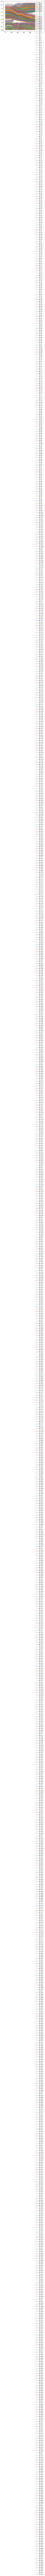

In [72]:
df.plot()

torch.Size([500, 600, 3])


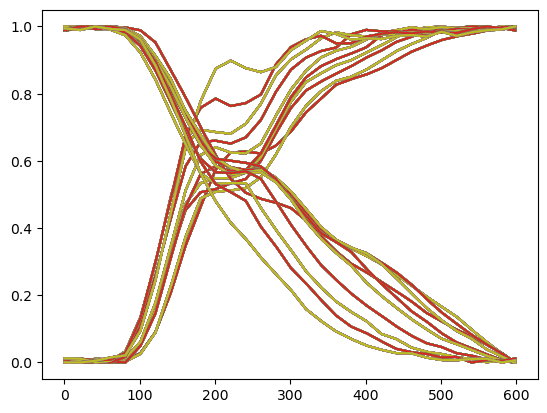

In [71]:
tensor = get_data(path="save_data_test.csv")
print(tensor.size())
tensor=tensor[1:500, :, :]
for x in tensor:
    plt.plot(x[:,0])
plt.show()

In [ ]:
tensor[:,566,2].size()

In [ ]:
df = pd.read_csv("save_data_test.csv", header=0, nrows=600, skiprows=[x for x in range(1,100)])
df